In [3]:
import polars as pl
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# scikit learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# if using colab
# raw_df = pl.read_csv('/content/sample_data/mnist_train_small.csv')

In [5]:
# read in the data MNIST data
raw_df = pl.read_csv('mnist_train_small.csv')

In [6]:
raw_df.head()
raw_df.shape

(19999, 785)

In [7]:
raw_df.head(3)

6,0,0_duplicated_0,0_duplicated_1,0_duplicated_2,0_duplicated_3,0_duplicated_4,0_duplicated_5,0_duplicated_6,0_duplicated_7,0_duplicated_8,0_duplicated_9,0_duplicated_10,0_duplicated_11,0_duplicated_12,0_duplicated_13,0_duplicated_14,0_duplicated_15,0_duplicated_16,0_duplicated_17,0_duplicated_18,0_duplicated_19,0_duplicated_20,0_duplicated_21,0_duplicated_22,0_duplicated_23,0_duplicated_24,0_duplicated_25,0_duplicated_26,0_duplicated_27,0_duplicated_28,0_duplicated_29,0_duplicated_30,0_duplicated_31,0_duplicated_32,0_duplicated_33,0_duplicated_34,…,0_duplicated_553,0_duplicated_554,0_duplicated_555,0_duplicated_556,0_duplicated_557,0_duplicated_558,0_duplicated_559,0_duplicated_560,0_duplicated_561,0_duplicated_562,0_duplicated_563,0_duplicated_564,0_duplicated_565,0_duplicated_566,0_duplicated_567,0_duplicated_568,0_duplicated_569,0_duplicated_570,0_duplicated_571,0_duplicated_572,0_duplicated_573,0_duplicated_574,0_duplicated_575,0_duplicated_576,0_duplicated_577,0_duplicated_578,0_duplicated_579,0_duplicated_580,0_duplicated_581,0_duplicated_582,0_duplicated_583,0_duplicated_584,0_duplicated_585,0_duplicated_586,0_duplicated_587,0_duplicated_588,0_duplicated_589
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# segregate the labels from the data
data = raw_df.select(raw_df.columns[1:])
labels = raw_df.select(raw_df.columns[0])

print(data.shape)
print(labels.shape)


(19999, 784)
(19999, 1)


In [9]:
# data.columns

In [10]:
# using scikit learn to normalize
scaler = MinMaxScaler()
dataNorm_np = scaler.fit_transform(data.to_numpy())

# convert numpy array to polars dataframe
dataNorm = pl.DataFrame(dataNorm_np, schema=data.columns)

# inspect the data
dataNorm.head()


0,0_duplicated_0,0_duplicated_1,0_duplicated_2,0_duplicated_3,0_duplicated_4,0_duplicated_5,0_duplicated_6,0_duplicated_7,0_duplicated_8,0_duplicated_9,0_duplicated_10,0_duplicated_11,0_duplicated_12,0_duplicated_13,0_duplicated_14,0_duplicated_15,0_duplicated_16,0_duplicated_17,0_duplicated_18,0_duplicated_19,0_duplicated_20,0_duplicated_21,0_duplicated_22,0_duplicated_23,0_duplicated_24,0_duplicated_25,0_duplicated_26,0_duplicated_27,0_duplicated_28,0_duplicated_29,0_duplicated_30,0_duplicated_31,0_duplicated_32,0_duplicated_33,0_duplicated_34,0_duplicated_35,…,0_duplicated_553,0_duplicated_554,0_duplicated_555,0_duplicated_556,0_duplicated_557,0_duplicated_558,0_duplicated_559,0_duplicated_560,0_duplicated_561,0_duplicated_562,0_duplicated_563,0_duplicated_564,0_duplicated_565,0_duplicated_566,0_duplicated_567,0_duplicated_568,0_duplicated_569,0_duplicated_570,0_duplicated_571,0_duplicated_572,0_duplicated_573,0_duplicated_574,0_duplicated_575,0_duplicated_576,0_duplicated_577,0_duplicated_578,0_duplicated_579,0_duplicated_580,0_duplicated_581,0_duplicated_582,0_duplicated_583,0_duplicated_584,0_duplicated_585,0_duplicated_586,0_duplicated_587,0_duplicated_588,0_duplicated_589
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
pl.DataFrame({
    'pixel_value' : dataNorm.to_numpy().flatten(),
    'data_type' : 'Normalized'
})

pixel_value,data_type
f64,str
0.0,"""Normalized"""
0.0,"""Normalized"""
0.0,"""Normalized"""
0.0,"""Normalized"""
0.0,"""Normalized"""
…,…
0.0,"""Normalized"""
0.0,"""Normalized"""
0.0,"""Normalized"""


In [12]:
# # inspect the normalized data
# px.histogram(
#     data_frame=pl.DataFrame({
#     'pixel_value' : dataNorm.to_numpy().flatten(),
#     'data_type' : 'Normalized'
#     }).sample(fraction=0.2), # too many rows so I sample a little
#     x='pixel_value',
#     nbins=50
#
# )

In [13]:

# convert to tensor data
labelT = torch.tensor(labels.to_series().to_numpy()).long()
dataT = torch.tensor(dataNorm.to_numpy()).float()

In [14]:
# split the tensor dataset
X_train, X_test, y_train, y_test = train_test_split(dataT, labelT, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, Training labels: {y_train.shape}")
print(f"Testing data: {X_test.shape}, Testing labels: {y_test.shape}")

Training data: torch.Size([15999, 784]), Training labels: torch.Size([15999])
Testing data: torch.Size([4000, 784]), Testing labels: torch.Size([4000])


In [15]:
# convert to dateaset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [16]:
# convert DataLoader
batchSize= 32
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [17]:
# check all the variables in the workspace
%whos

Variable                        Type             Data/Info
----------------------------------------------------------
DataLoader                      type             <class 'torch.utils.data.dataloader.DataLoader'>
F                               module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
MinMaxScaler                    type             <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
TensorDataset                   type             <class 'torch.utils.data.dataset.TensorDataset'>
X_test                          Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
X_train                         Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
batchSize                       int              32
data                            DataFrame        shape: (19_999, 784)\n┌──<...>┴───────────┴───────────┘
dataNorm                        DataFrame        shape: (19_999, 784)\n┌──<...>┴───────────┴───────────┘
data

## Create DL model

In [18]:
# define a class
class ANN(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(784, 64)

        # hidden layer
        self.hidden1 = nn.Linear(64, 32)
        self.hidden2 = nn.Linear(32, 32)

        # output layer
        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))

        # return log softmax as the output
        return torch.log_softmax(self.output(x), axis=1)


In [19]:
# function to create the other components
def createTheANNnet(learningRate=0.01, epochStep=10, gamma=1/2):
    model = ANN()
    lossfunc = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

    step_size = len(train_loader) * epochStep
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    return model, lossfunc, optimizer, scheduler

### Test the model

In [20]:
# test the model with one batch
model, lossfunc, optimizer, scheduler= createTheANNnet(learningRate=0.01, epochStep=5, gamma=1/2)

X, y = next(iter(train_loader))
yhat = model(X)

loss = lossfunc(yhat, y)
print(loss)

# the results:
# tensor(2.2816, grad_fn=<NllLossBackward0>)

tensor(2.3288, grad_fn=<NllLossBackward0>)


In [21]:
# Backward pass to compute gradients
loss.backward()

# Now, let's inspect gradients for some parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} grad shape: {param.grad.shape}")
        print(f"{name} grad sample:\n{param.grad[:2]}\n")  # show just first 2 rows/values

input.weight grad shape: torch.Size([64, 784])
input.weight grad sample:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

input.bias grad shape: torch.Size([64])
input.bias grad sample:
tensor([ 0.0002, -0.0005])

hidden1.weight grad shape: torch.Size([32, 64])
hidden1.weight grad sample:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0

## Create a function that trains the model

In [22]:
def trainModel(train_loader, test_loader, numepochs=100, toggleDynamicLR=True):
    # define the empty dataframe
    training_progress = pl.DataFrame(
        schema=[
            ('iteration', pl.Int64),
            ('epoch', pl.Int64),
            ('train_loss', pl.Float64),
            ('train_acc', pl.Float64),
            ('test_loss', pl.Float64),
            ('test_acc', pl.Float64),
            ('learning_rate', pl.Float64)
        ]
    )

    iteration = 0
    # create the ANN net
    model, lossfunc, optimizer, scheduler = createTheANNnet(learningRate=0.01, epochStep=5, gamma=1/2)

    # Get test data once (since we're using a test_loader that loads all data at once)
    X_testTL, y_testTL = next(iter(test_loader))

    for epoch in range(numepochs):
        # Epoch training mode
        model.train()

        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = 0

        # Iterate through training batches
        for X_trainTL, y_trainTL in train_loader:
            yhat_train = model(X_trainTL)
            train_loss = lossfunc(yhat_train, y_trainTL)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if toggleDynamicLR:
                scheduler.step()
                current_lrs = scheduler.get_last_lr()[0]
            else:
                current_lrs = optimizer.param_groups[0]['lr']

            # Accuracy
            train_matches = (torch.argmax(yhat_train, axis=1) == y_trainTL).float()
            train_acc = 100 * torch.mean(train_matches)

            # num_batches = This is simply a counter for how many batches were processed in the epoch.
            # epoch_train_loss = This is a running total of the training loss for all batches in the current epoch.
            # epoch_train_loss / num_batches computes the average training loss per batch during the epoch.
            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_acc.item()

            num_batches += 1

        # End of epoch: evaluate test set ONCE
        model.eval()
        with torch.no_grad():
            yhat_test = model(X_testTL)
            test_loss = lossfunc(yhat_test, y_testTL)
            test_matches = (torch.argmax(yhat_test, axis=1) == y_testTL).float()
            test_acc = 100 * torch.mean(test_matches)

        # Log single row per epoch
        new_row = pl.DataFrame([{
            'iteration': iteration,
            'epoch': epoch,
            'train_loss': epoch_train_loss / num_batches,
            'train_acc': epoch_train_acc / num_batches,
            'test_loss': test_loss.item(),
            'test_acc': test_acc.item(),
            'learning_rate': current_lrs
        }])

        training_progress = pl.concat([training_progress, new_row])
        iteration += 1

        if epoch % 10 == 0 or epoch == numepochs - 1:
            print(
                f"Epoch {epoch+1}/{numepochs} - "
                f"Training: Loss={epoch_train_loss / num_batches:.4f}, "
                f"Accuracy={epoch_train_acc / num_batches:.2f}% | "
                f"Testing: Loss={test_loss.item():.4f}, "
                f"Accuracy={test_acc.item():.2f}% | "
                f"Learning Rate: {current_lrs:.6f}"
            )

    return training_progress, model




In [23]:
# test the model
training_progress, model = trainModel(train_loader=train_loader, test_loader=test_loader, numepochs=30, toggleDynamicLR=True)

Epoch 1/30 - Training: Loss=0.4671, Accuracy=85.37% | Testing: Loss=0.2661, Accuracy=92.45% | Learning Rate: 0.010000
Epoch 11/30 - Training: Loss=0.0285, Accuracy=99.12% | Testing: Loss=0.1917, Accuracy=96.15% | Learning Rate: 0.002500
Epoch 21/30 - Training: Loss=0.0022, Accuracy=99.92% | Testing: Loss=0.2875, Accuracy=96.25% | Learning Rate: 0.000625
Epoch 30/30 - Training: Loss=0.0006, Accuracy=99.99% | Testing: Loss=0.3583, Accuracy=96.07% | Learning Rate: 0.000156


In [24]:
# group to get the average of per epoch
import polars.selectors as cs

epoch_avg = (
    training_progress
    .group_by('epoch')
    .agg(
        cs.numeric().mean().name.prefix('mean_')
    )
)

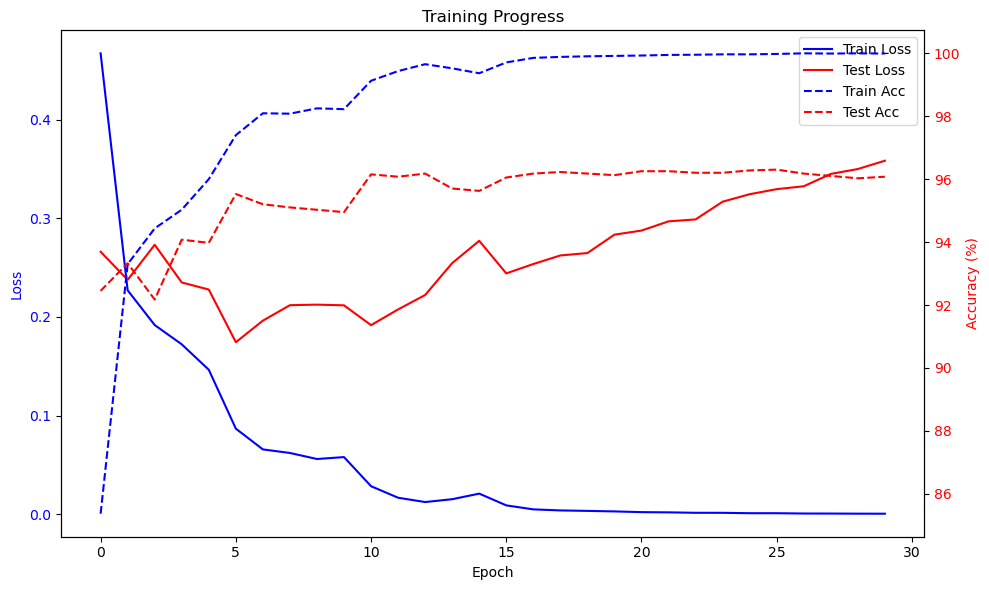

In [25]:
# Plot training progress
import matplotlib.pyplot as plt

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot losses on left axis - using your grouped data
ax1.plot(epoch_avg['epoch'].to_numpy(), epoch_avg['mean_train_loss'].to_numpy(), 'b-', label='Train Loss')
ax1.plot(epoch_avg['epoch'].to_numpy(), epoch_avg['mean_test_loss'].to_numpy(), 'r-', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot accuracies on right axis
ax2.plot(epoch_avg['epoch'].to_numpy(), epoch_avg['mean_train_acc'].to_numpy(), 'b--', label='Train Acc')
ax2.plot(epoch_avg['epoch'].to_numpy(), epoch_avg['mean_test_acc'].to_numpy(), 'r--', label='Test Acc')
ax2.set_ylabel('Accuracy (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training Progress')
plt.tight_layout()
plt.show()

In [26]:
# Final model evaluation
model.eval()
with torch.no_grad():
    X_testTL, y_testTL = next(iter(test_loader))
    yhat_test = model(X_testTL)
    test_loss = lossfunc(yhat_test, y_testTL)

    # Calculate test accuracy
    test_matches = (torch.argmax(yhat_test, axis=1) == y_testTL).float()
    test_acc = 100 * torch.mean(test_matches)

    print(f"\nFinal model performance - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Final model performance - Test Loss: 0.3583, Test Accuracy: 96.07%


In [27]:
# this is the softmax function
yhat_test[123]

tensor([-46.4768, -32.6952, -38.4149, -50.3046,   0.0000, -37.3915, -43.2132,
        -29.4055, -42.8673, -29.6677])

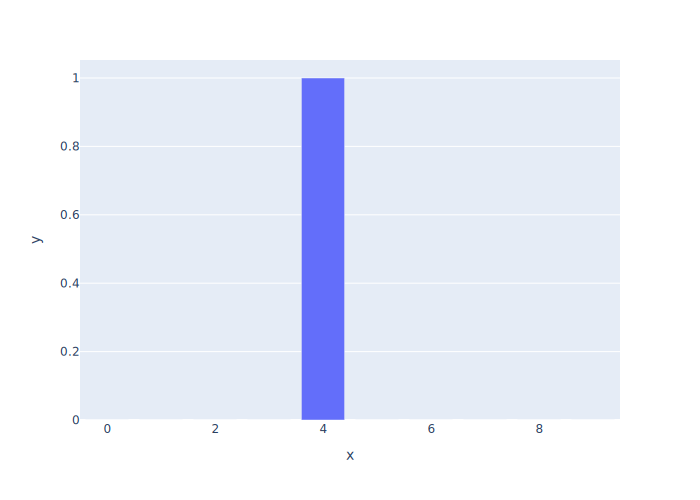

In [40]:
# inspect the numbers from one sample
# use the exponent to reverse the effect log softmax
px.bar(x=range(10), y=torch.exp(yhat_test[34])).show(renderer='svg')

In [29]:
# check what is the real answer
y_testTL[34]

tensor(9)

In [30]:
# find the errors
# errors = np.where( torch.max(yhat_test,axis=1)[1] != y )[0]
# print(errors)

In [31]:
yhat_test[34]

tensor([-1.9914e+01, -1.6639e+01, -1.7053e+01, -1.9480e+01, -5.8412e-06,
        -1.5624e+01, -1.8767e+01, -1.3238e+01, -1.7544e+01, -1.2482e+01])

In [32]:
np.argmax(yhat_test.numpy(), axis=1)[34]

np.int64(4)

In [33]:
(yhat_test[43])

tensor([-1.7638e+01, -1.6444e+01, -2.1826e+01, -9.4165e+00, -6.4778e+00,
        -1.4498e+01, -3.5756e+01, -1.0292e+01, -1.5296e+01, -1.6547e-03])

In [34]:
np.exp(yhat_test[43])

/var/folders/f8/vcqysvdd39j1b3z4bt0ttjt40000gn/T/ipykernel_25547/843111899.py:1: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



tensor([2.1875e-08, 7.2173e-08, 3.3211e-10, 8.1374e-05, 1.5371e-03, 5.0533e-07,
        2.9613e-16, 3.3915e-05, 2.2753e-07, 9.9835e-01])

In [35]:
# The index of the maximum value corresponds to the predicted class label
wrong_predictions = pl.DataFrame({
    'true_label': y_testTL.numpy(),
    'predicted_label' : np.argmax(yhat_test.numpy(), axis=1)
})

wrong_predictions

true_label,predicted_label
i64,i64
7,7
7,7
0,0
9,9
4,4
…,…
7,7
0,9
6,6


In [36]:
# find all the rows with wrong predictions
(
    wrong_predictions
    .with_row_index(name='index')
    .filter(pl.col('true_label') != pl.col('predicted_label'))
)

index,true_label,predicted_label
u32,i64,i64
34,9,4
159,5,6
172,4,8
179,3,7
197,9,5
…,…,…
3915,9,3
3932,8,5
3966,5,6


In [37]:
# reshaping the row of pixels
np.reshape(data[52, :], (28,28))

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

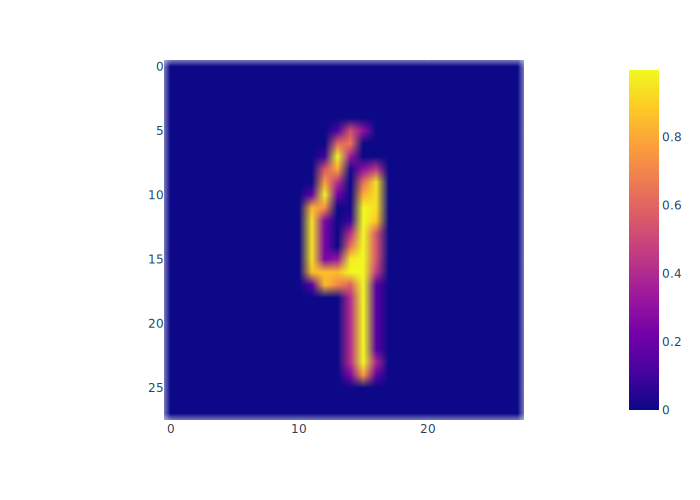

In [39]:
# check a wrong prediction
px.imshow(
    np.reshape(X_test[34, :], (28,28))
).show(renderer='svg')